In [1]:
%matplotlib inline
import os
import pandas as pd

from datetime import datetime, date, timedelta
import matplotlib as mpl
import dateutil
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams
import seaborn as sns
import locale
import requests
from pandas import ExcelWriter
import numpy as np
# import matplotlib.ticker as tick

In [170]:
def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

In [68]:
sns.set(style='ticks')
# pal = sns.color_palette([
#     [31 / 255, 73 / 255, 125 / 255], #JPMBlue
#     [247 / 255, 150 / 255, 70 / 255], #JPMOrange
#     [155 / 255, 187 / 255, 89 / 255] #JPMGreen
# ])

pal = sns.color_palette([
    [222 / 255, 110 / 255, 116 / 255], #JPMBlue
    [101 / 255, 134 / 255, 194 / 255], #JPMOrange
    [43 / 255, 175 / 255, 100 / 255] #JPMGreen
])

linestyles = [
    {'c': pal[0], 'linestyle': '-'}, 
    {'c': pal[1], 'linestyle': '-'}, 
    {'c': pal[0], 'linestyle': 'dashed'}, 
    {'c': pal[1], 'linestyle': 'dashed'}, 
    {'c': pal[0], 'linestyle': ':'}, 
    {'c': pal[1], 'linestyle': ':'}, 
    {'c': pal[2], 'linestyle': '-'}, 
    {'c': pal[2], 'linestyle': 'dashed'}, 
    {'c': pal[2], 'linestyle': ':'}, 
    
]

barstyles = [
    {'color': pal[0], },
    {'color': pal[0], },
    {'edgecolor': pal[0], 'color': 'white', 'linewidth': 1, 'hatch': '////'},
    {'edgecolor': pal[1], 'color': 'white', 'linewidth': 1, 'hatch': '////'},
    {'edgecolor': pal[0], 'color': 'white', 'linewidth': 1, 'hatch': '....'},
    {'edgecolor': pal[1], 'color': 'white', 'linewidth': 1, 'hatch': '....'},
    
]

rcParams = {
    'font.family' : 'sans-serif',
    'font.sans-serif' : 'Arial',
    'font.weight' : 'bold',
    'font.stretch' : 'condensed',
    'figure.autolayout' : False,
    'hatch.linewidth' : 0.2
}

csfont = {'fontname':'Comic Sans MS'}
hfont = {'fontname':'Helvetica'}
# Plantagenet Cherokee

# CHARTDIR
SAVEFIG_KWARGS = {'dpi': 72*4}
LEGEND_KWARGS = {'frameon': True, 'framealpha': 0.9, 'labelspacing': 0.4}
CHART_GAP = timedelta(days=20)
CHART_TITLE_ALIGN = 'left'

# yearsFmt = mdates.DateFormatter('%b-%Y')
# yearsFmt = mdates.DateFormatter('%b-%d')
# yearsFmt = mdates.DateFormatter('%Y')
fontsize = 15
fontweight = 'regular'
title_fontsize = 15
title_fontweight = 'regular'
tick_label_size = 15
tick_label_weight = 'regular'
legend_title_fontsize = 15
legend_title_fontweight = 'regular'
legend_label_fontsize = 15
legend_label_fontweight = 'regular'

annotation_fontsize = 15
annotation_fontweight = 'regular'
xticks_params = {
    'pad' : 1,
    'length' : 3,
}
yticks_params = {
    'pad' : 2,
    'length' : 2,
}

savefig_params = {
    'bbox_inches' : 'tight',
    'pad_inches' : 0.4,
}
xlabel_params = {
    'position' : (0.5,0.5),
    'fontsize' : 15,
    'fontweight' : 'regular',
    'labelpad': None,
}
ylabel_params = {
    'fontsize' : 15,
    'fontweight' : 'regular',
}

from matplotlib.ticker import FuncFormatter
def crores(x,pos):
    return '%1.1f' % (x*1e-7)

formatter_cr = FuncFormatter(crores)

footnote_fontsize = 15
footnote_fontweight = 'regular'
fontname = "Baskerville"
def apply_to_axes(axes, footnote_text = 'AllStuffData'):
    _axes = (axes,) if not isinstance(axes, tuple) else axes
    for ax in axes:
        ax.xaxis.label.set_fontsize(xlabel_params['fontsize'])
        ax.yaxis.label.set_fontsize(ylabel_params['fontsize'])
        for item in [ax.xaxis.label, ax.yaxis.label]:
            item.set_fontweight(fontweight)
            item.set_fontname(fontname)
        
        ax.title.set_fontsize(title_fontsize)
        ax.title.set_fontweight(title_fontweight)
        ax.title.set_fontname(fontname)
        
        for item in ax.get_xticklabels() + ax.get_yticklabels():
            item.set_fontsize(tick_label_size)
            item.set_fontweight(tick_label_weight)
            item.set_fontname(fontname)
            
        if ax.get_legend() is not None:
            lt = ax.get_legend().get_title()
            lt.set_fontsize(legend_title_fontsize)
            lt.set_fontweight(legend_title_fontweight)
            lt.set_fontname(fontname)
            t0 = ax.get_legend().get_texts()[0]
            t0.set_fontsize(legend_label_fontsize)
            t0.set_fontweight(legend_label_fontweight)
            t0.set_fontname(fontname)
        
        footnote = ax.annotate(footnote_text, **footnote_params)
        footnote.set_fontsize(footnote_fontsize)
        footnote.set_fontname(fontname)
        footnote.set_fontweight(footnote_fontweight)
        
    return axes

In [69]:
x_min = datetime(2013,3,1)
x_max = date.today() + timedelta(100)
tickrule = dateutil.rrule.rrule(
    freq = dateutil.rrule.DAILY,
    interval = 366,
    dtstart = x_min,
    until = x_max,
)
pal = sns.color_palette([
    [0 / 255, 255 / 255, 255 / 255], #Blue
    [255 / 255, 255 / 255, 102 / 255], #Yellow
    [255 / 255, 80 / 255, 80 / 255], #Red
    [255 / 255, 153 / 255, 102 / 255] #Orange
])
yearsFmt = mdates.DateFormatter('%Y')
footnote_params = {
    'xy': (0,-0.02),
    'xycoords':'axes fraction',
    'xytext': (0,-24),
    'textcoords': 'offset points',
    'va': 'top',
    
}
legend_placement_kwargs = {
    'loc': 'upper center',
    'bbox_to_anchor': (.5,-0.06),
    'ncol': 3,
}

grid_kwargs = {
    'linestyle': '-',
    'linewidth': 0.5,
#     'color': 3,
}


SAVEFIG_KWARGS = {'dpi': 72*4}

COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['lines.color'] = COLOR
mpl.rcParams['axes.edgecolor'] = COLOR

In [4]:
os.chdir('MGNREGA')

In [5]:
dfs = []
for name in os.listdir(os.getcwd()):
    try:
        year = name.split("_")[0]
        type_ = name.split("_")[2].split(".")[0]
        df = pd.read_html(name)[0]
        df = df.drop(df.index[[0,2,3]])
        new_header = df.iloc[0] #grab the first row for the header
        new_header = new_header.tolist()
        for i,item in enumerate(new_header):
            if (i > 1) & ( i<11):
                new_header[i] = "01-"+item+"-"+str(year)
            elif (i >10):
                new_header[i] = "01-"+item+"-"+str(int(year)+1)
        df = df[1:] #take the data less the header row
        df.columns = new_header #set the header row as the df header
        del df['S.No']
        df = df.T
        new_header = df.iloc[0] #grab the first row for the header
        df = df[1:] #take the data less the header row
        df.columns = new_header #set the header row as the df header
        df.columns.name = None
        df.index = pd.to_datetime(df.index)
#         df['Total'] = df.sum(axis=1)
        req_cols = df.columns
        df = df.reset_index()
        df = pd.melt(df, id_vars=['index'], value_vars=req_cols)
        df = df[['index','variable','value']]
        df.columns = ['date','state','value']
        df['type'] = type_
        dfs.append(df)
    except:
        print(name)

.DS_Store


In [6]:
os.chdir("..")

In [7]:
os.getcwd()

'/Users/gopal/Desktop/AllStuffData/notebooks'

In [78]:
df = pd.concat(dfs, axis = 0)
df.type.unique()

array(['Household', 'Persondays'], dtype=object)

In [79]:
df.to_excel("MNREGA.xlsx")

In [74]:
df2 = df[df.state == 'Total']


In [75]:
df1 = df2[df2.type == 'Household']
df1 = df1.sort_values(by='date')
df1 = df1[['date','value']]
df1.date = df1.date.dt.to_period(freq='D')
df1 = df1.set_index('date')
df1 = df1[:-9] # Change this index as new data gets added
df1['value'] = pd.to_numeric(df1['value'])

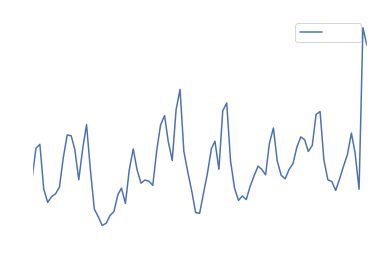

In [11]:
df1.plot.line()

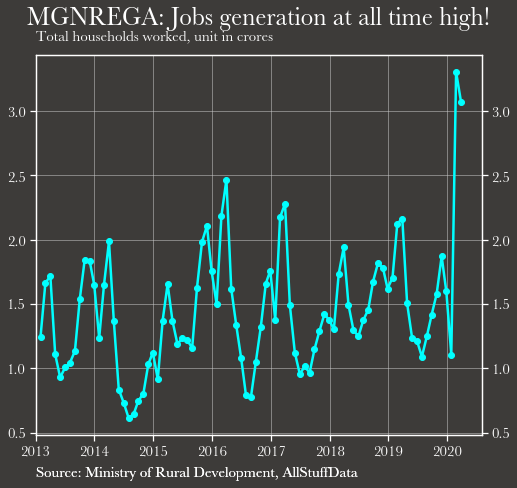

In [77]:
fig, ax = plt.subplots(figsize=(8,7))
for i, item in enumerate(list(df1.columns)):
    df_ = df1[[item]]
    mask = df_[item].notnull()
    ax.plot(df_.index[mask].start_time.values, df_[item][mask], c=pal[0],label = item, linewidth=2.5, zorder = 2, marker='o')
    
mpl.rcParams['savefig.facecolor'] = (61.0/255, 58.5/255, 57.0/255)
ax.set_facecolor((61.0/255, 58.5/255, 57.0/255))
fig.patch.set_facecolor((61.0/255, 58.5/255, 57.0/255))

ax.set_xticks([_ for _ in tickrule])
ax.grid(b=None, which='major', axis='both',**grid_kwargs)
ax.set_xlim([mdates.date2num(x_min),mdates.date2num(x_max)])
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())


fig.text(0.125,0.91,"Total households worked, unit in crores",fontdict={'fontsize':15,'fontweight':'regular','fontname':'Baskerville'})
footnote_text = "Source: Ministry of Rural Development, AllStuffData"
apply_to_axes((ax,ax1),footnote_text = footnote_text)
ax.set_title('MGNREGA: Jobs generation at all time high!', loc='center', fontdict={'fontsize':25,'fontweight':'bold', 'fontname':'Baskerville'}, pad=30 )

ax.xaxis.set_major_formatter(yearsFmt)
ax.get_yaxis().set_major_formatter(formatter_cr)
ax1.get_yaxis().set_major_formatter(formatter_cr)
f = os.path.dirname(os.getcwd())+'/todays_chart/nrega_1.jpg'
fig.savefig(f, **SAVEFIG_KWARGS, **savefig_params, transparent = True)

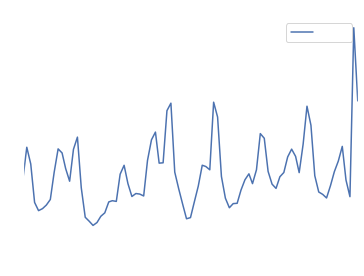

In [60]:
df1 = df2[df2.type == 'Persondays']
df1 = df1.sort_values(by='date')
df1 = df1[['date','value']]
df1.date = df1.date.dt.to_period(freq='D')
df1 = df1.set_index('date')
df1 = df1[:-9] # Change this index as new data gets added
df1['value'] = pd.to_numeric(df1['value'])
df1.plot.line()

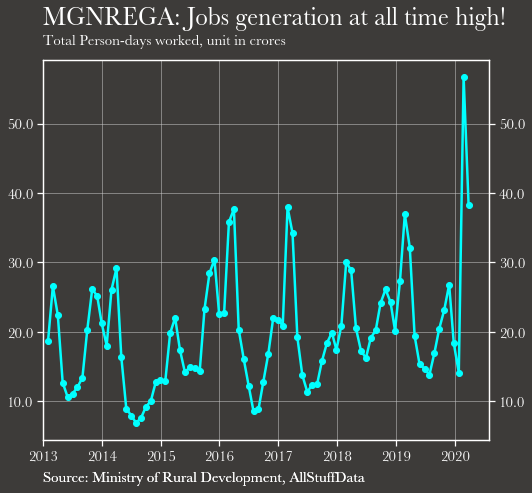

In [71]:
fig, ax = plt.subplots(figsize=(8,7))
for i, item in enumerate(list(df1.columns)):
    df_ = df1[[item]]
    mask = df_[item].notnull()
    ax.plot(df_.index[mask].start_time.values, df_[item][mask], c=pal[0],label = item, linewidth=2.5, zorder = 2, marker='o')
    
mpl.rcParams['savefig.facecolor'] = (61.0/255, 58.5/255, 57.0/255)
ax.set_facecolor((61.0/255, 58.5/255, 57.0/255))
fig.patch.set_facecolor((61.0/255, 58.5/255, 57.0/255))

ax.set_xticks([_ for _ in tickrule])
ax.grid(b=None, which='major', axis='both',**grid_kwargs)
ax.set_xlim([mdates.date2num(x_min),mdates.date2num(x_max)])
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())



fig.text(0.125,0.91,"Total Person-days worked, unit in crores",fontdict={'fontsize':15,'fontweight':'regular','fontname':'Baskerville'})
footnote_text = "Source: Ministry of Rural Development, AllStuffData"
apply_to_axes((ax,ax1),footnote_text = footnote_text)
ax.set_title('MGNREGA: Jobs generation at all time high!', loc=CHART_TITLE_ALIGN, fontdict={'fontsize':25,'fontweight':'bold', 'fontname':'Baskerville'}, pad=35 )

ax.xaxis.set_major_formatter(yearsFmt)
ax.get_yaxis().set_major_formatter(formatter_cr)
ax1.get_yaxis().set_major_formatter(formatter_cr)
f = os.path.dirname(os.getcwd())+'/todays_chart/nrega_2.jpg'
fig.savefig(f, **SAVEFIG_KWARGS, **savefig_params, transparent = True)